In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
words = open('names.txt', 'r').read().splitlines()

In [11]:
# build vocabulay of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [12]:
# build the dataset
block_size = 3 #how many characters used to predict next one?
def build_dataset(data):
    
    block_size = 3 #how many chars used for prediction
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, rolling window
    return torch.tensor(X), torch.tensor(Y)
import random
random.seed(42)
random.shuffle(words)
split1 = int(0.8 * len(words))
split2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:split1])
X_val, Y_val = build_dataset(words[split1:split2])
X_test, Y_test = build_dataset(words[split2:])


In [31]:
# MLP revisited
n_embed = 10 # dimension of embedding space
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # why does Andrej like this seed? lol
C = torch.randn((vocab_size, n_embed), generator=g) # embedding space of 2 for each of 27 chars
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0 # 0 vector at initializaiton
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [33]:
from tqdm import tqdm
max_steps = 200000
batch_size = 32
lossi = []
for i in tqdm(range(max_steps)):    
    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    
    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix]) 
    # print(loss.item())    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 1000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

  0%|                                                | 0/200000 [00:00<?, ?it/s]

      0 /  200000: 2.5329


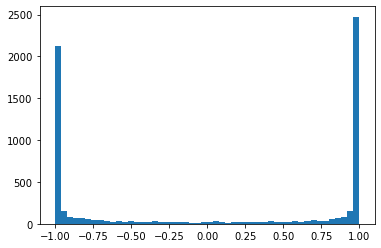

In [37]:
plt.hist(.view(-1).tolist(),50); # very active tanh

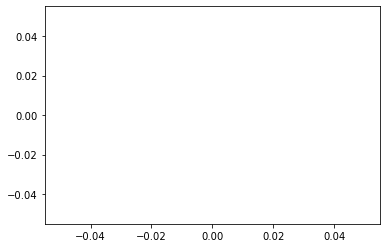

In [22]:
plt.plot(lossi)

In [23]:
# split evaluation
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[X_val] # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, Y_val) 
    print(split, loss.item())    
split_loss('train')
split_loss('val')

train 2.1719658374786377
val 2.1719658374786377


In [27]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass through nn
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print word

carlah.
aal.
havi.
kimri.
reviy.
halayan.
jazhuen.
delyah.
jareen.
nermara.
chaiivia.
leigh.
ham.
jorn.
quint.
shous.
alian.
quinathonderryn.
karmekailyan.
edalaiia.
